### CRC183 Summer School "Machine Learning in Condensed Matter Physics"
# Hands-on session: Learning a phase transition by looking at snapshots of a quantum state

## Installing JAX, NetKet & Co.

In today's session you will learn about basics of JAX and the Netket library. Installing NetKet is relatively straightforward and it will automatically install JAX as a dependency. 

For this Tutorial, **if you are running it locally on your machine**, we recommend that you create a clean virtual environment and install NetKet within: 

```bash
python3 -m venv netket
source netket/bin/activate
pip install --pre netket
```

If you are wondering why we use the flag ```--pre``` it is because today we will be working on a pre (beta) release of version 3.0. 

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
!pip install --pre -U netket

You can check that the installation was succesfull doing

In [1]:
import jax

Import also a few other packages:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as jnp
import netket as nk
import flax
import flax.linen as nn
from netket.operator.spin import sigmax,sigmaz 

# To measure the time it takes to train a network
import time

from jax import grad, jit, vmap, value_and_grad
from jax.scipy.special import logsumexp # Computes the log of the sum of exponentials of input elements.
from jax.experimental import optimizers

import numpy as np

# Learning a phase transition by looking at snapshots of a quantum state

The idea of this notebook is to combine Variational Monte Carlo (NetKet) and the supervised learning approach to detect phase transitions.

# Generate data with NQS+VMC

First, do a VMC ground state search with NetKet.

## Set up the Hilbert space

In [3]:
N=20

hi = nk.hilbert.Spin(s=1 / 2, N=N)

## Define an ansatz for the variational wave function

In [4]:
import netket.nn as nknn

graph=nk.graph.Chain(length=N,pbc=True)

class SymmModel(nknn.Module):
    alpha: int

    @nknn.compact
    def __call__(self, x):
        
        x = nknn.DenseSymm(symmetries=graph.translation_group(),
                           features=self.alpha,
                           kernel_init=nk.nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))

In [5]:
model=SymmModel(alpha=4)

## Get the training data: Sample "snapshots" from the ground state

In [6]:
sampler = nk.sampler.MetropolisLocal(hi)

def get_gs_sample(H, sampler, model, n_samples):
    
    vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

    optimizer = nk.optimizer.Sgd(learning_rate=0.1)

    gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

    log=nk.logging.RuntimeLog()
    gs.run(n_iter=300,out=log)
    
    s = vstate.sample()
    s = s.reshape(-1, s.shape[2])[:n_samples,:]
    
    return s

## Generate data

Here, we generate data for a range of transverse fields $g$ of the quantum Ising model

$$
H = -\sum_l\sigma_l^z\sigma_{l+1}^z-g\sum_l\sigma_l^x
$$

In [7]:
all_data = {}
gs=jnp.arange(0.1,2,0.1)

for g in gs:
    H = sum([-g*sigmax(hi,i) for i in range(N)])

    J=-1
    H += sum([J*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

    s=get_gs_sample(H, sampler, model, 500)

    all_data['%.3f'%(g)] = s

100%|██████████| 300/300 [00:14<00:00, 20.89it/s, Energy=-40.68061 ± 0.00018 [σ²=0.00003, R̂=0.9991]]


# Supervised learning

## Prepare training data

Here we organize the training data analogous to Notebook 3.

In [8]:
def get_training_data(all_data, gs, gc=1.0, train_fraction=0.8):
    # Lists to store the raw data
    raw_g = []
    raw_x = []
    raw_y = [] 
    
    for g in gs:      
        raw_x.append(all_data['%.3f'%(g)])
        n = len(all_data['%.3f'%(g)])
        label = [1,0] if g < gc else [0,1]
        raw_y.append(np.array([label] * n))
        raw_g.append(np.array([g]*n))
        
    raw_g = np.concatenate(raw_g)
    raw_x = np.concatenate(raw_x, axis=0)
    raw_y = np.concatenate(raw_y, axis=0)
    
    # Shuffle
    indices = np.random.permutation(len(raw_x))
    all_g = raw_g[indices]
    all_x = raw_x[indices]
    all_y = raw_y[indices]

    # Split into train and test sets
    train_split = int(train_fraction * len(all_x))
    train_g = jnp.array(all_g[:train_split])
    train_x = jnp.array(all_x[:train_split])
    train_y = jnp.array(all_y[:train_split])
    test_g = jnp.array(all_g[train_split:])
    test_x = jnp.array(all_x[train_split:])
    test_y = jnp.array(all_y[train_split:])
    
    return [raw_g, raw_x, raw_y], [train_g, train_x, train_y], [test_g, test_x, test_y]

In [9]:
# Pick only the gs at the beginning and at the end, and construct a dataset
train_gs = list(gs[:2]) + list(gs[-2:])
[raw_g, raw_x, raw_y], [train_g, train_x, train_y], [test_g, test_x, test_y] = get_training_data(all_data, train_gs)

## Define a deep learning model

In [10]:
from typing import Sequence

class MyNet(nn.Module):
    layers: Sequence[int] # A tuple that contains the widths of all layers follwing the input layer
    
    @nn.compact
    def __call__(self, x):

        a = x.ravel() # flatten the input

        # Evaluate network layer by layer
        for width in self.layers[:-1]:
            # Apply a the Dense layer with given width followed by the non-linearity
            a = nn.relu(nn.Dense(width)(a))
          
        a = nn.Dense(self.layers[-1])(a)
        
        # Return activations of the output layer
        return a - logsumexp(a)

In [11]:
net = MyNet(layers=[100, 64, 32, 2])

Define a `predict` function that uses the ANN to predict labels for a batch of input data.

In [12]:
# Make a batched version of the `predict` function
predict = jax.vmap(lambda p, x: net.apply(p,x), in_axes=(None, 0), out_axes=0)

## Define a loss function

In [13]:
def loss(params, images, targets):
    preds = predict(params, images)
    return -jnp.mean(preds * targets)

## Set up the training loop

In [14]:
def accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def train(train_x, train_y, test_x, test_y, num_epochs, batch_size, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_x, train_y)
    test_acc = accuracy(params, test_x, test_y)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Divide into batches
    num_batches = len(train_x) // batch_size

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Shuffle data
        indices = np.random.permutation(len(train_x))
        batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)
        
        for b in range(len(batch_indices)):
            x = train_x[batch_indices[b]]
            y = train_y[batch_indices[b]]
            
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_x, train_y)
        test_acc = accuracy(params, test_x, test_y)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | Time: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

        
    return train_loss, log_acc_train, log_acc_test, params

## Define the optimizer and the update step

In [15]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)

@jax.jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

## Blanking: train model in known limits, then use it to predict the rest

In [16]:
# Initialize a net
params = net.init(jax.random.PRNGKey(1234), train_x[0])

# Initialize the optimizer
opt_state = opt_init(params)

Epoch 1 | Time: 1.02 | Train A: 0.996 | Test A: 0.990
Epoch 2 | Time: 0.07 | Train A: 0.996 | Test A: 0.990
Epoch 3 | Time: 0.07 | Train A: 0.996 | Test A: 0.995
Epoch 4 | Time: 0.07 | Train A: 0.998 | Test A: 0.993
Epoch 5 | Time: 0.07 | Train A: 0.998 | Test A: 0.995
Epoch 6 | Time: 0.07 | Train A: 0.998 | Test A: 0.993
Epoch 7 | Time: 0.08 | Train A: 0.999 | Test A: 0.998
Epoch 8 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 9 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 10 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 11 | Time: 0.07 | Train A: 0.999 | Test A: 0.995
Epoch 12 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 13 | Time: 0.08 | Train A: 0.999 | Test A: 0.998
Epoch 14 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 15 | Time: 0.08 | Train A: 0.999 | Test A: 0.998
Epoch 16 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 17 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 18 | Time: 0.07 | Train A: 0.999 | Test A: 0.998
Epoch 19 | Time: 0.

Text(0, 0.5, 'Loss')

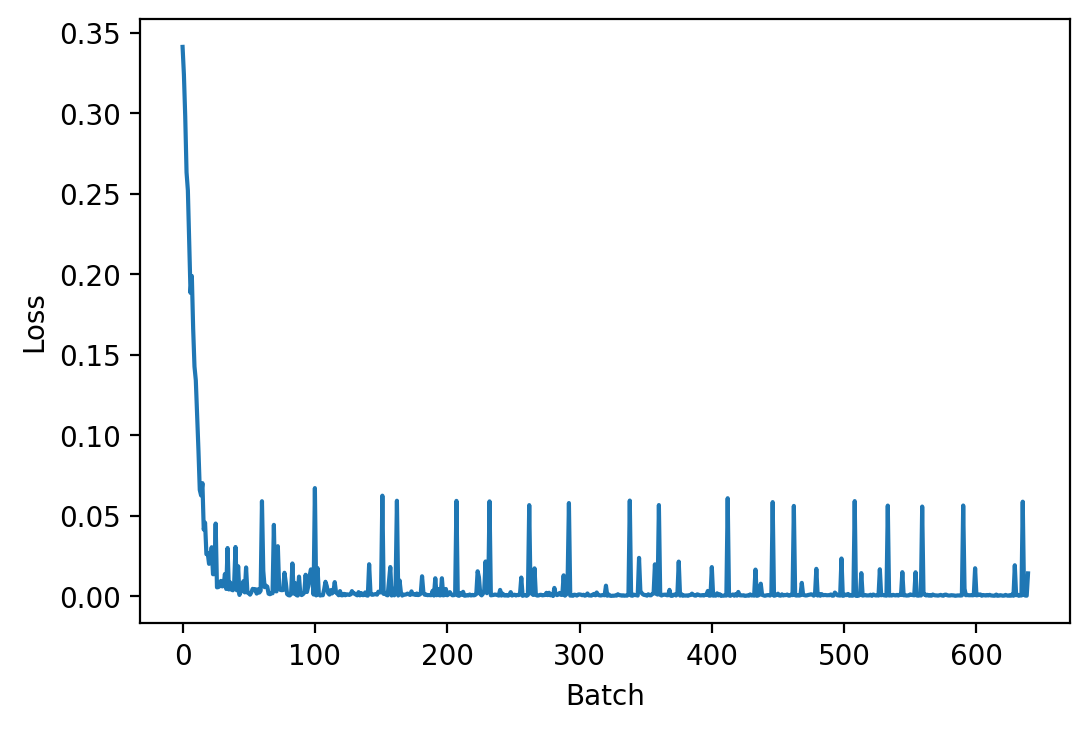

In [17]:
train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 20, 32, opt_state)

fig, ax = plt.subplots(dpi=200)
ax.plot(train_loss)
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")

## Predict for all $g$

In [18]:
# For every temperature, get the averaged prediction
predictions = []
for g in gs:
    x = all_data['%.3f'%g]#['x']
    p = jnp.exp( predict(params, x) )  # Exponentiate it to go back to the [0,1] range for nicer plotting
    p = jnp.mean( p, axis=0 )
    predictions.append(p)

Text(0, 0.5, 'Predictions')

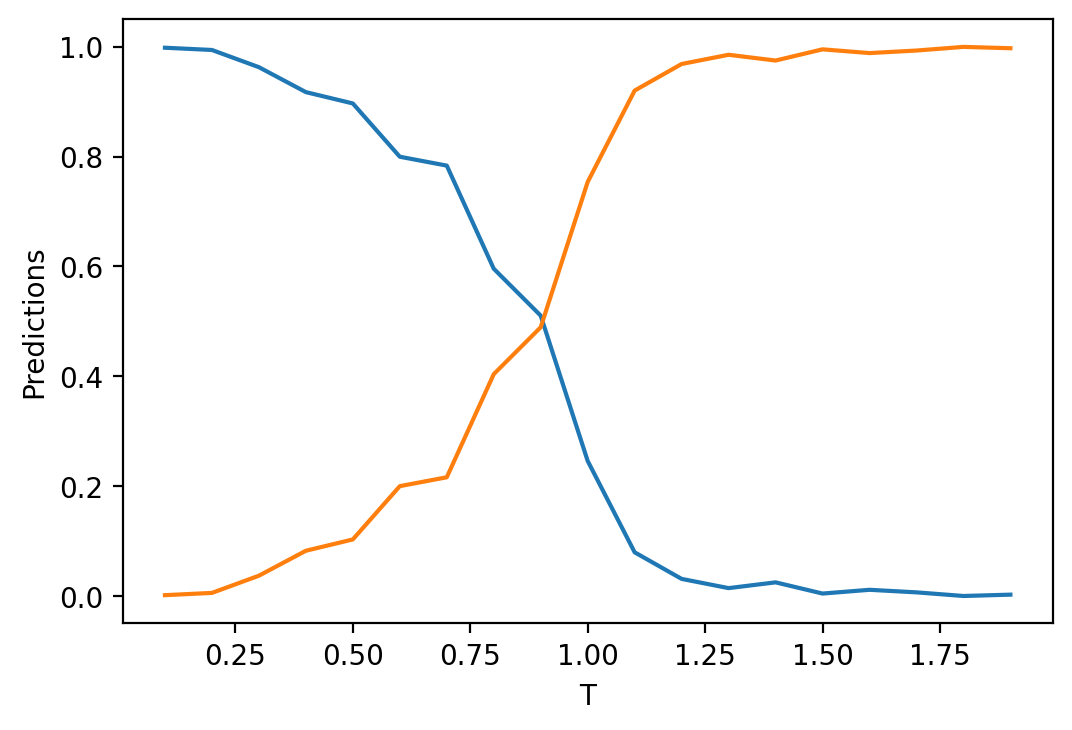

In [19]:
fig, ax = plt.subplots(dpi=200)
ax.plot( gs, predictions )
ax.set_xlabel("T")
ax.set_ylabel("Predictions")